<a href="https://colab.research.google.com/github/nimab16/Real_Fake_Face/blob/main/Multi_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/Real_fake/archive.zip -d /content/drive/MyDrive/Real_fake

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 34.5 MB/s 


In [ ]:
import numpy as np  
import pandas as pd 
import os
import shutil
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
import cv2 
from keras import utils as np_utils
from keras.utils.np_utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
#import mtcnn
from mtcnn.mtcnn import MTCNN


#create a detector
detector = MTCNN()
#detect face in a single image
def detect_face(path):
    read_image = cv2.imread(path)
    image=cv2.cvtColor(read_image,cv2.COLOR_BGR2RGB) 
    
    
    image=np.array(image)
    #detect faces in the image
    result=detector.detect_faces(image)
    #if no face is detected return an empty list
    if len(result)==0:
        return []
    #extract the bounding box of the face
    x1,y1,width,height=result[0]['box']
    #extract the face
    x1,y1,width,height=x1,y1,width,height
    face=image[y1:y1+height,x1:x1+width]
    #resize the face to a fixed size
    #face=cv2.resize(face,(160,160))
    return face

#face=detect_face(fi)
#plt.imshow(face)
#plt.show()

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/Real_fake/real_and_fake_face'
TRAIN_DIR = '/content/drive/MyDrive/Real_fake/train_dataset'
TEST_DIR = '/content/drive/MyDrive/Real_fake/test_dataset'

RATE = 0.2 # splitting proportion for training and test datasets

In [ ]:
os.mkdir(TRAIN_DIR)
os.mkdir(TRAIN_DIR+'/fake')
os.mkdir(TRAIN_DIR+'/real')

os.mkdir(TEST_DIR)
os.mkdir(TEST_DIR+'/fake')
os.mkdir(TEST_DIR+'/real')

FileExistsError: ignored

In [ ]:
# Split image files into test and training set 
# OPTION 2 (copying files into newly created folders)
files_real = os.listdir(f'{DATASET_DIR}/training_real')
files_fake = os.listdir(f'{DATASET_DIR}/training_fake')


# sample from each class to create a test set
np.random.seed(0)
files_real_test = np.random.choice(
    files_real,
    size=round(len(files_real) * RATE),
    replace=False,
    p=None)

files_real_train = list(set(files_real) - set(files_real_test)) #[file for file in files_real if file not in files_real_test] 

files_fake_test = np.random.choice(
    files_fake,
    size=round(len(files_fake) * RATE),
    replace=False,
    p=None)

files_fake_train = list(set(files_fake) - set(files_fake_test)) #[file for file in files_fake if file not in files_fake_test] 

for file in files_real_train:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TRAIN_DIR+'/real/'+file) 

for file in files_fake_train:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TRAIN_DIR+'/fake/'+file) 

for file in files_real_test:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TEST_DIR+'/real/'+file) 

for file in files_fake_test:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TEST_DIR+'/fake/'+file) 

In [ ]:
train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_samples = sum([len(files) for r, d, files in os.walk(TEST_DIR)])
print('Number of training images: {} \nNumber of test images: {}'.format(train_samples, test_samples))

Number of training images: 1633 
Number of test images: 408


In [ ]:
def get_images(path, img_shape=(64, 64), color='rgb'):
 
    main_path = path
    y = []
    list = [name for name in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, name))]
    print(list)
    image_collection = []
    for idx,folder in enumerate(list):
 
        label = idx
        
        sub_list = sorted(os.listdir(os.path.join(main_path,folder)))
 
        for i in tqdm(range(1, len(sub_list))):
        #for i in tqdm(range(1, 10)):
            image_path = os.path.join(main_path, folder, sub_list[i])
            try:
                image = detect_face(image_path)
                #plt.imshow(image)
                #read_image = cv2.imread(image_path)
                #if color == 'rgb':
                #    image=cv2.cvtColor(read_image,cv2.COLOR_BGR2RGB)
                                        
                if color == 'YCrCb':
                    image=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
                                            
                if color == 'Luv':
                    image=cv2.cvtColor(image,cv2.COLOR_RGB2Luv)

                image_resized = cv2.resize(image, img_shape, interpolation=cv2.INTER_AREA)
                image = np.float32(image_resized)
                image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Change alpha, beta according to the preprocessing you desire

                image_collection.append(image)

                y.append(label)
            except:
                continue 

    y = np.array(y)
    y = to_categorical(y,num_classes=len(list))
 
    return image_collection, y[:,0] 

In [ ]:
img_shape=(128, 128)
X_train,y_train = get_images(TRAIN_DIR,img_shape, color='rgb')
X_test,y_test = get_images(TEST_DIR,img_shape, color='rgb')
X_train = np.array(X_train)
X_test = np.array(X_test)

X_YCrCb_train,y_YCrCb_train = get_images(TRAIN_DIR,img_shape, color='YCrCb')
X_YCrCb_test,y_YCrCb_test = get_images(TEST_DIR,img_shape, color='YCrCb')
X_YCrCb_train = np.array(X_YCrCb_train)
X_YCrCb_test = np.array(X_YCrCb_test)


X_Luv_train,y_Luv_train = get_images(TRAIN_DIR,img_shape, color='Luv')
X_Luv_test,y_Luv_test = get_images(TEST_DIR,img_shape, color='Luv')
X_Luv_train = np.array(X_Luv_train)
X_Luv_test = np.array(X_Luv_test)

['fake', 'real']


100%|██████████| 864/864 [08:50<00:00,  1.63it/s]


['fake', 'real']


100%|██████████| 215/215 [02:11<00:00,  1.64it/s]


['fake', 'real']


100%|██████████| 864/864 [08:52<00:00,  1.62it/s]


['fake', 'real']


100%|██████████| 215/215 [02:12<00:00,  1.63it/s]


['fake', 'real']


100%|██████████| 864/864 [08:53<00:00,  1.62it/s]


['fake', 'real']


100%|██████████| 215/215 [02:11<00:00,  1.64it/s]


In [ ]:
print('Training set', X_train.shape)
print('Test set', X_test.shape)

Training set (1626, 128, 128, 3)
Test set (405, 128, 128, 3)


RGB mtcnn


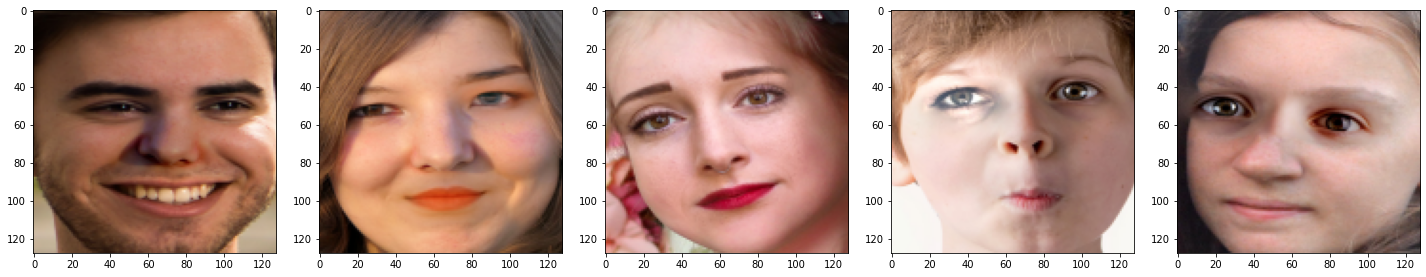

In [ ]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
print('RGB mtcnn')
plotImages(X_train[:5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mtcnn


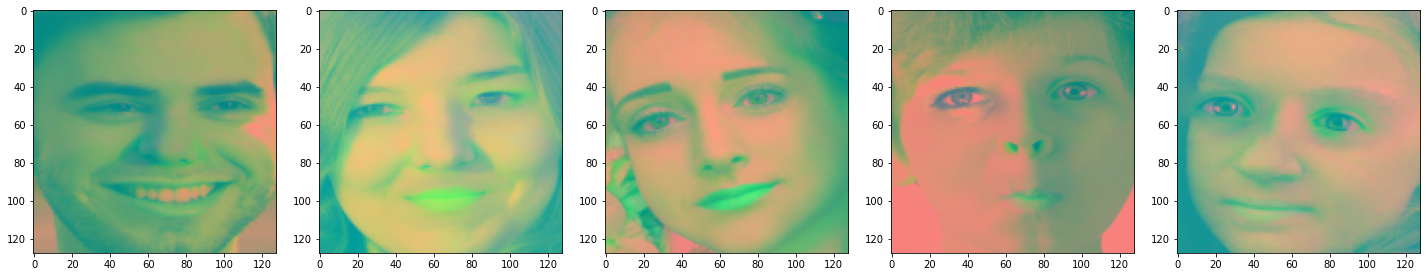

In [ ]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
print('mtcnn')
plotImages(X_YCrCb_train[:5])

 mtcnn


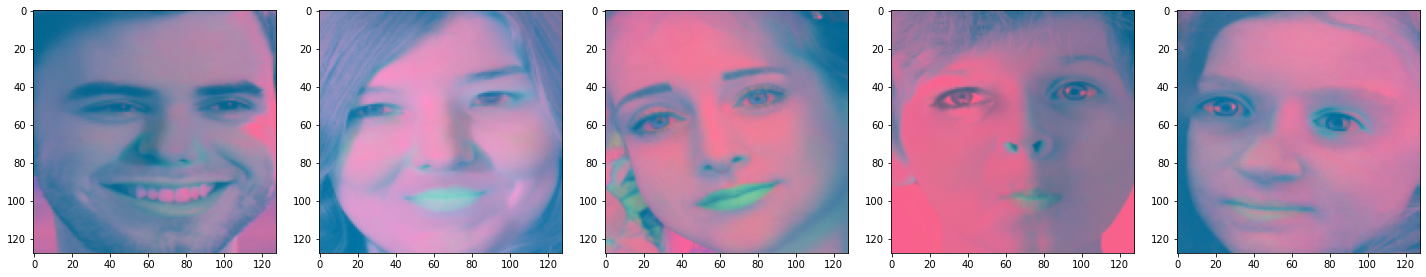

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
print(' mtcnn')
plotImages(X_Luv_train[:5])

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_YCrCb_train, y_YCrCb_train = shuffle(X_YCrCb_train, y_YCrCb_train)
X_Luv_train, y_Luv_train = shuffle(X_Luv_train, y_Luv_train)

In [ ]:
import tensorflow as tf

# 1
input_1 = tf.keras.layers.Input(shape=(128, 128, 3))
conv2d1_1 = tf.keras.layers.Conv2D(32, kernel_size=3, activation=tf.keras.activations.relu)(input_1)
maxpool1_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2d1_1)

conv2d1_2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation=tf.keras.activations.relu)(maxpool1_1)
maxpool1_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2d1_2)

conv2d1_3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation=tf.keras.activations.relu)(maxpool1_2)

flatten_1 = tf.keras.layers.Flatten()(conv2d1_3)

A = tf.keras.Model(inputs=input_1, outputs=flatten_1)



# 2
input_2 = tf.keras.layers.Input(shape=(128, 128, 3))
conv2d2_1 = tf.keras.layers.Conv2D(32, kernel_size=3, activation=tf.keras.activations.relu)(input_2)
maxpool2_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2d2_1)

conv2d2_2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation=tf.keras.activations.relu)(maxpool2_1)
maxpool2_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2d2_2)

conv2d2_3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation=tf.keras.activations.relu)(maxpool2_2)

flatten_2 = tf.keras.layers.Flatten()(conv2d2_3)

B = tf.keras.Model(inputs=input_2, outputs=flatten_2)


# Concatenate
concat = tf.keras.layers.Concatenate()([A.output, B.output])


# output layer
cout = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu)(concat)
drop = tf.keras.layers.Dropout(0.5)(cout)
output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(drop)

full_model = tf.keras.Model(inputs=[A.input, B.input], outputs=output)

print(full_model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 126, 126, 32  896         ['input_4[0][0]']                
                                )                                                           

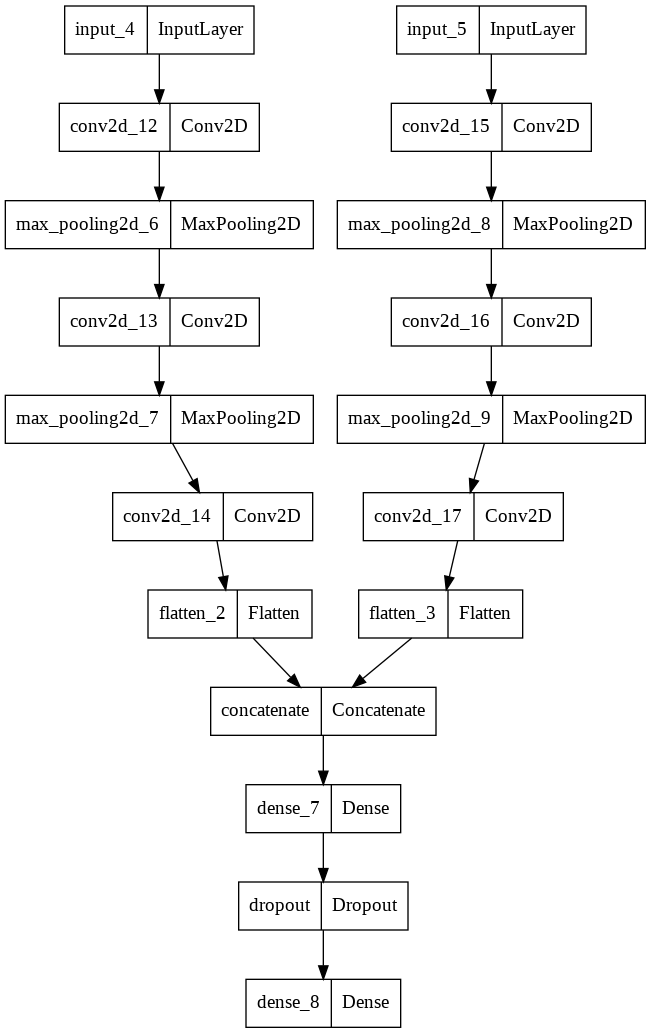

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(full_model)

In [ ]:
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
y1 = np.asarray(y_Luv_train).astype('float32').reshape((-1,1))
y2 = np.asarray(y_YCrCb_train).astype('float32').reshape((-1,1))
#y3 = np.asarray(y1_valid).astype('float32').reshape((-1,1))

In [ ]:
his = full_model.fit([X_Luv_train, X_YCrCb_train], [y1, y2], batch_size=12, epochs=100,verbose=True)

Epoch 1/100
136/136 [==============================] - 2s 14ms/step - loss: 0.6916 - binary_accuracy: 0.5289
Epoch 2/100
136/136 [==============================] - 2s 14ms/step - loss: 0.6915 - binary_accuracy: 0.5289
Epoch 3/100
136/136 [==============================] - 2s 14ms/step - loss: 0.6917 - binary_accuracy: 0.5289
Epoch 4/100
136/136 [==============================] - 2s 14ms/step - loss: 0.6918 - binary_accuracy: 0.5289
Epoch 5/100
136/136 [==============================] - 2s 14ms/step - loss: 0.6921 - binary_accuracy: 0.5289
Epoch 6/100
136/136 [==============================] - 2s 13ms/step - loss: 0.6915 - binary_accuracy: 0.5289
Epoch 7/100
136/136 [==============================] - 2s 14ms/step - loss: 0.6916 - binary_accuracy: 0.5289
Epoch 8/100
136/136 [==============================] - 2s 13ms/step - loss: 0.6919 - binary_accuracy: 0.5289
Epoch 9/100
136/136 [==============================] - 2s 15ms/step - loss: 0.6919 - binary_accuracy: 0.5289
Epoch 10/100
136/13

KeyboardInterrupt: ignored

In [ ]:
X_train.shape

(1626, 128, 128, 3)

In [ ]:
full_model.save("/content/drive/MyDrive/Real_fake/full_model.h5")

In [ ]:
predict = full_model.predict([X_Luv_test, X_YCrCb_test])

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fpr, tpr, thresholds = roc_curve(y_test, predict[:, 0])
roc_auc = auc(fpr, tpr)

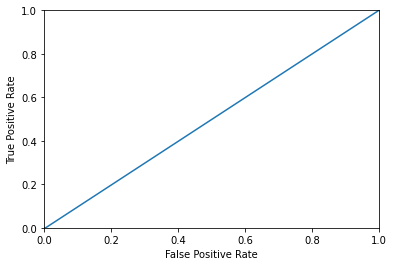

In [ ]:
from matplotlib import pyplot as pit
def plot_roc_curve(fpr,tpr,roc_auc):
    pit.plot(fpr,tpr, label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.axis([0,1,0,1])
    pit.xlabel('False Positive Rate') 
    pit.ylabel('True Positive Rate') 
    pit.show()
    

plot_roc_curve(fpr,tpr,roc_auc)

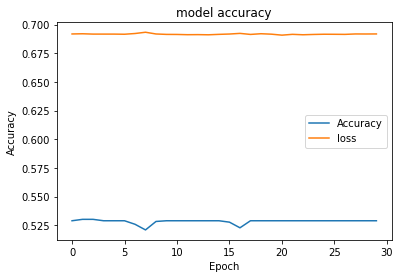

In [ ]:
import matplotlib.pyplot as plt
plt.plot(his.history["binary_accuracy"])
plt.plot(his.history['loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()